## Import Modules

In [1]:
import pandas as pd
import datetime as dtm
from IPython.display import Image
import logging
import json

from strategy_builder import build_decision_tree_from_specs, validate_specs
from strategy_execution import basket_creation_method
from helper import allocate_values
from strategy_builder import validate_specs

import sigtech.framework as sig

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
env = sig.init()

SigTech environment successfully initialized


## Define Strategy Parameters and Load Specifications

In [2]:
# Define ETFs with complete names
etfs = {
    'TLT US EQUITY': sig.obj.get('TLT US EQUITY'), 
    'TQQQ US EQUITY': sig.obj.get('TQQQ US EQUITY'),
    'SVXY US EQUITY': sig.obj.get('SVXY US EQUITY'),
    'VIXY US EQUITY': sig.obj.get('VIXY US EQUITY'),
    'QQQ UP EQUITY': sig.obj.get('QQQ UP EQUITY'),
    'SPY UP EQUITY': sig.obj.get('SPY UP EQUITY'),
    'BND UP EQUITY': sig.obj.get('BND UP EQUITY'),
    'BIL UP EQUITY': sig.obj.get('BIL UP EQUITY'),
    'GLD UP EQUITY': sig.obj.get('GLD UP EQUITY'),
}

# Retrieve ETF histories
etf_histories = {name: etf.history() for name, etf in etfs.items()}

# Define date range and initial cash
START_DATE = dtm.date(2024, 6, 2)
END_DATE = dtm.date(2024, 6, 30)
INITIAL_CASH = 1e6

# Example dates for decision tree evaluation
example_dates = [
    dtm.datetime(2024, 6, 30, 14, 50, 0),
    dtm.datetime(2024, 6, 27, 0, 0, 0),
    dtm.datetime(2024, 6, 26, 0, 0, 0),
    dtm.datetime(2024, 6, 25, 0, 0, 0),
    dtm.datetime(2024, 6, 24, 0, 0, 0),
    dtm.datetime(2024, 6, 21, 0, 0, 0),
    dtm.datetime(2024, 6, 20, 0, 0, 0),
    dtm.datetime(2024, 6, 18, 0, 0, 0),
    dtm.datetime(2024, 6, 17, 0, 0, 0),
    dtm.datetime(2024, 6, 14, 0, 0, 0),
    dtm.datetime(2024, 6, 13, 0, 0, 0),
    dtm.datetime(2024, 6, 12, 0, 0, 0),
    dtm.datetime(2024, 6, 11, 0, 0, 0),
    dtm.datetime(2024, 6, 10, 0, 0, 0),
    dtm.datetime(2024, 6, 7, 0, 0, 0),
    dtm.datetime(2024, 6, 6, 0, 0, 0),
    dtm.datetime(2024, 6, 5, 0, 0, 0),
    dtm.datetime(2024, 6, 4, 0, 0, 0),
    dtm.datetime(2024, 6, 3, 0, 0, 0)
]

# Load condition specifications from JSON files
with open('conditions.json', 'r') as f:
    condition_specs = json.load(f)

with open('actions.json', 'r') as f:
    action_specs = json.load(f)


## Initialize and Build the Strategy

In [3]:
# Validate specifications before building
if validate_specs(condition_specs, action_specs):
    # Initialize the Dynamic Strategy
    strat = sig.DynamicStrategy(
        currency='USD',
        start_date=START_DATE,
        end_date=END_DATE,
        trade_frequency='1BD',
        basket_creation_method=basket_creation_method,
        basket_creation_kwargs={
            'example_dates': example_dates,
            'etf_histories': etf_histories,
            'etfs': etfs,
            'condition_specs': condition_specs,
            'action_specs': action_specs
        },
        initial_cash=INITIAL_CASH,
    )

    # Build the strategy
    strat.build(progress=True)
else:
    logger.error("Invalid condition or action specifications. Strategy build aborted.")


  0%|                                                   | 0/100 [00:00<?, ?it/s]

[DecisionNode] Evaluating condition: RSI(QQQ UP EQUITY, 20) > 70 with threshold 70
[DecisionNode] Indicator Value for QQQ UP EQUITY: 58.8593954517936
[DecisionNode] Condition Met: False
[DecisionNode] Condition false. Traversing to False branch.
[DecisionNode] Evaluating condition: Volatility(VIXY US EQUITY, 11) > 0.025 with threshold 0.025
[DecisionNode] Indicator Value for VIXY US EQUITY: 0.0235520369951749
[DecisionNode] Condition Met: False
[DecisionNode] Condition false. Traversing to False branch.
[DecisionNode] Evaluating condition: RSI(QQQ UP EQUITY, 31) < 10 with threshold 10
[DecisionNode] Indicator Value for QQQ UP EQUITY: 57.71592996579445
[DecisionNode] Condition Met: False
[DecisionNode] Condition false. Traversing to False branch.
[ActionNode] Executing action: Allocate BIL UP EQUITY: 25.0%, SPY UP EQUITY: 25.0%, TLT US EQUITY: 25.0%, GLD UP EQUITY: 25.0%
[ActionNode] Allocations: {'BIL UP EQUITY': 2734.3322760581864, 'SPY UP EQUITY': 473.6642667677151, 'TLT US EQUITY': 

## Visualize the Decision Tree

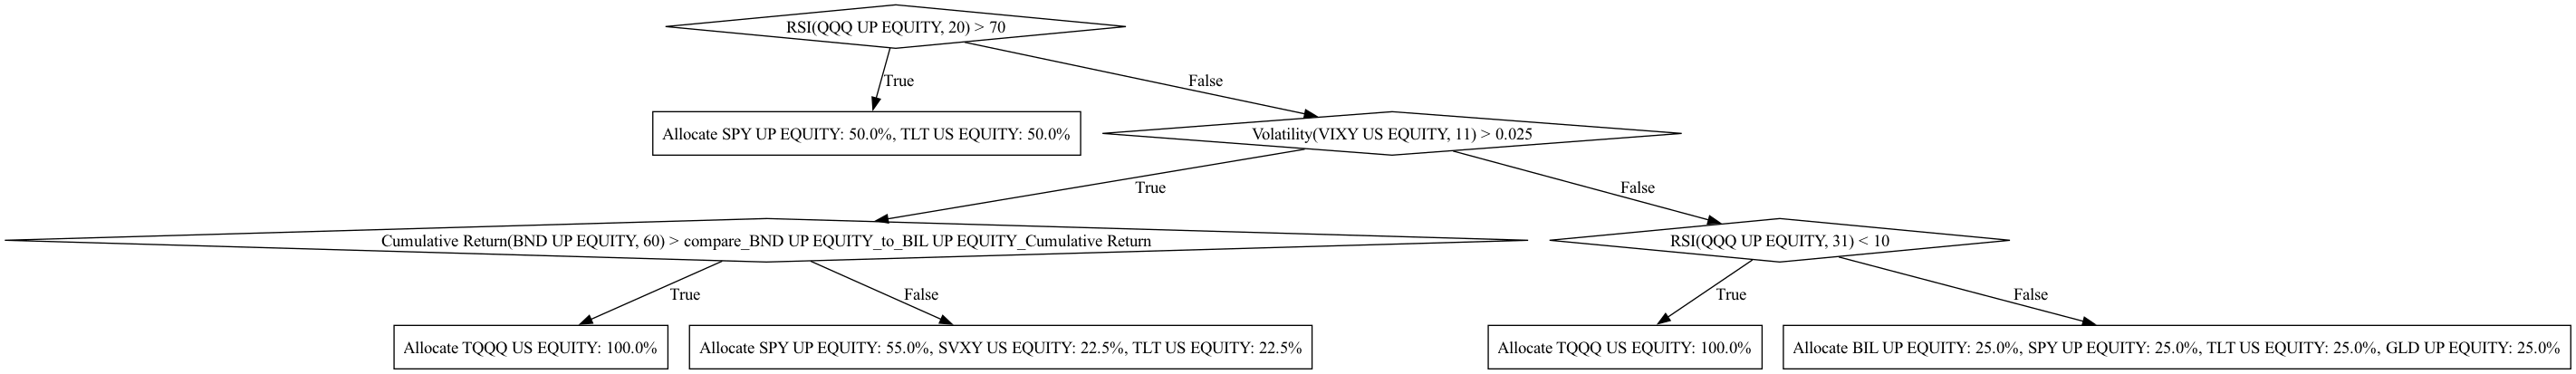

In [8]:
from strategy_builder import build_decision_tree_from_specs

# Build the decision tree
decision_tree = build_decision_tree_from_specs(condition_specs, action_specs)

# Plot and display the tree
dot = decision_tree.plot_tree(decision_tree.root)
dot.format = 'png'
dot.render('decision_tree', view=False)
Image(filename='decision_tree.png')